In [1]:
import tensorflow as tf
import os
import random
import numpy as np
import helpers
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [3]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 80
IMG_HEIGHT = 80
IMG_CHANNELS = 3

TRAIN_PATH_IMAGES = 'training/images/'
TRAIN_PATH_GROUNDTRUTH = 'training/groundtruth/'
TEST_PATH = 'test_set_images/'

train_ids = os.listdir(TRAIN_PATH_IMAGES)
test_ids = os.listdir(TEST_PATH)

train_len = len(train_ids)*25
test_len = len(test_ids)*25

X_train = np.zeros((train_len, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((train_len, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool_)

In [4]:
def split_into_patches(img, patchsize):
    assert patchsize % 16 == 0 and 400 % patchsize == 0, "Invalid patchsize. Must be in {16, 80, 400}."
    sub_images = []
    width = img.shape[0]
    height = img.shape[1]
    for x in range(width // patchsize):
        for y in range(height // patchsize):
            tlc = (x*patchsize, y*patchsize) # Top left corner
            sub_images.append(img[tlc[0]:tlc[0]+patchsize,tlc[1]:tlc[1]+patchsize])
    return np.array(sub_images)



In [5]:
print('Resizing training images and masks')
position1 = 0
position2 = 0
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    imgs = imread(TRAIN_PATH_IMAGES + id_)[:,:,:IMG_CHANNELS]  
    imgs = split_into_patches(imgs,80)
    for img in imgs:
        X_train[position1] = img
        position1 += 1
    #img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    masks = imread(TRAIN_PATH_GROUNDTRUTH + id_)
    masks = split_into_patches(masks,80)
    masks = np.expand_dims(masks, axis=3)
    for mask in masks:
        Y_train[position2] = mask
        position2 += 1

Resizing training images and masks


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 56.11it/s]


In [6]:
  

# test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    imgs = imread(path + '/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    imgs = split_into_patches(imgs,80)
    for img in imgs:
        X_test[n] = img

print('Done!')

Resizing test images


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 58.51it/s]

Done!


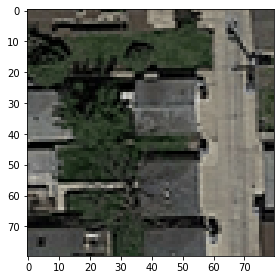

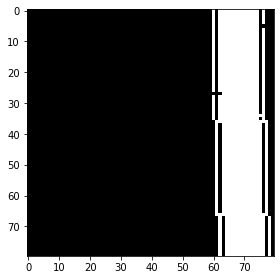

In [7]:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [8]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 lambda (Lambda)                (None, 80, 80, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 16)   448         ['lambda[0][0]']                 
                                                                                                  
 dropout (Dropout)              (None, 80, 80, 16)   0           ['conv2d[0][0]']                 
                                                                                              

In [9]:
################################
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

####################################

Epoch 1/25
141/141 [==============================] - 55s 377ms/step - loss: 0.5156 - accuracy: 0.7760 - val_loss: 0.5488 - val_accuracy: 0.7488
Epoch 2/25
141/141 [==============================] - 52s 367ms/step - loss: 0.4668 - accuracy: 0.7776 - val_loss: 0.5094 - val_accuracy: 0.7488
Epoch 3/25
141/141 [==============================] - 52s 367ms/step - loss: 0.4333 - accuracy: 0.7787 - val_loss: 0.4981 - val_accuracy: 0.7053
Epoch 4/25
141/141 [==============================] - 53s 377ms/step - loss: 0.4157 - accuracy: 0.7934 - val_loss: 0.5416 - val_accuracy: 0.6933
Epoch 5/25
141/141 [==============================] - 52s 369ms/step - loss: 0.4019 - accuracy: 0.8026 - val_loss: 0.5130 - val_accuracy: 0.6846


2/2 [==============================] - 0s 66ms/step


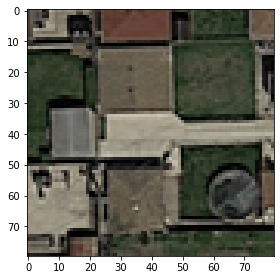

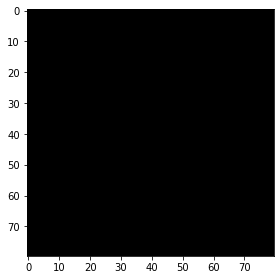

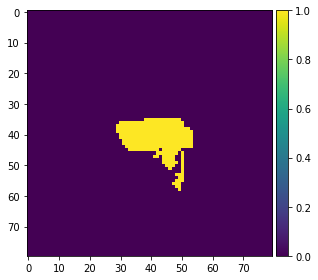

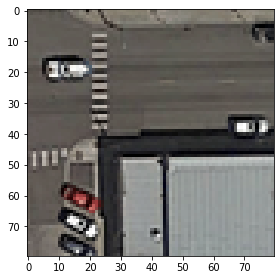

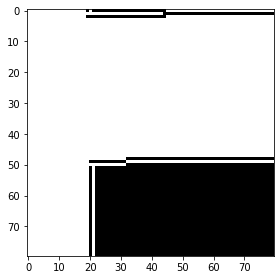

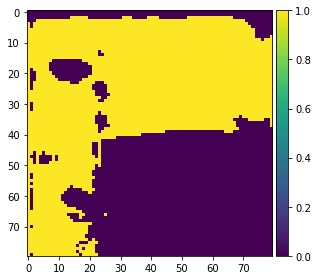

In [28]:
idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()